# Preparatory steps



In [1]:
# access data from the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# alternative: upload files
# from google.colab import files
# uploaded = files.upload()

### Installing necessary packages

Install the necessary bert packages and Tensorflow 1.15.2

In [2]:
!pip uninstall gast
!pip install gast==0.2.2
!pip install sentencepiece
!pip install bert-tensorflow==1.0.1
!pip install pandas==0.24

Uninstalling gast-0.3.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/gast-0.3.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/gast/*
Proceed (y/n)? y
  Successfully uninstalled gast-0.3.3
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=76e68fbb3860cbf8be12c583d1aa5d483ab342c3f7271ccd41f818899736963f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 1.2MB 11.7MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 10.1MB 27.7MB/s 
ERROR: xarray 0.18.0 has requirement pandas>=1.0, but you'll have pandas 0.24.0 which is incompatible.
ERROR: plotnine 0.6.0 

After restarting the runtime as suggested, run following:

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# for importing modules in .py files, insert the working directory
import sys
sys.path.insert(0,'/content/drive/My Drive/AIandLaw/CodeAndModel/')

# Predict

This can be used to predict the labels (hateful or not) of new data with existing models.
Before you run it, you have to change the following input variables;
- data_path: Location of the new data.
- bert_model_path: Location of the BERT model.
- xgb_model_path: Location of the predictions model.
- bert_output_path = Location where the BERT features should be saved.
- predictions_output_path = Location where the predictions are saved.
The data_path should point to a csv file with a column called "Comment_text".
BERT is a huge machine learning model and it takes quite long to generate features with it, that why the BERT
features are stored. If for some reason an error happens afterwards, the BERT features don't have to be computed again.
The output is a csv file with three columns: the original comment, the predicted probability that is is a hateful
comment and the binary prediction (True if the predicted probability is greater than 0.5).
To execute the script you just need to change the variables in the "User Input" section and then run the script.

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf

from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

from bert_functions_modified import *
from functions_modified import *

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [6]:
# --------- User Input ----------------------------
data_path = "/content/drive/My Drive/AIandLaw/CodeAndModel/dataset/test_data_hate_speech.csv"
bert_model_path = "/content/drive/My Drive/AIandLaw/CodeAndModel/bert_model_updated.h5"
xgb_model_path = "/content/drive/My Drive/AIandLaw/CodeAndModel/xgboost_model.dat"
bert_output_path = "/content/drive/My Drive/AIandLaw/CodeAndModel/bert_output.csv"
predictions_output_path = "/content/drive/My Drive/AIandLaw/CodeAndModel/predictions.csv"

In [7]:
new_data = pd.read_csv(data_path)

In [8]:
sess = tf.Session()
max_seq_length = 256
bert_model = build_model(max_seq_length, bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1")
initialize_vars(sess)
bert_model.load_weights(bert_model_path)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]            

### Instantly evaluating single comment without XGBoost 

For testing purposes. Enter a text in the INPUT TEXT cell and run it to instantly detect hate speech without needing to save it as .csv first.

Note: need to build the model first from previous cells

In [9]:
tokenizer = create_tokenizer_from_hub_module("https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1", sess)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [10]:
def evaluateTextForHateSpeech(text, tokenizer):
  text = str(text)
  text = text = [' '.join(str(text).split()[0:max_seq_length])]
  text = np.array(text, dtype=object)[:, np.newaxis]
  pseudo_label = [1] * len(text)

  example = convert_text_to_examples(text, pseudo_label)
  (input_ids, input_masks, segment_ids, labels) = convert_examples_to_features(tokenizer, example, max_seq_length=max_seq_length)

  prediction = bert_model.predict([input_ids, input_masks, segment_ids])

  if prediction > 0.5:
    return "Hate speech detected"
  else:
    return "No hate speech detected"

In [11]:
#INPUT TEXT
textToBeEvaluated = "White people are trashy."

In [12]:
evaluateTextForHateSpeech(textToBeEvaluated, tokenizer)

'Hate speech detected'

### Create dataset for BERT

In [13]:
# create datasets for BERT
text = new_data['Comment_text'].tolist()
text = [' '.join(str(t).split()[0:max_seq_length]) for t in text]
text = np.array(text, dtype=object)[:, np.newaxis]
pseudo_label = [1] * len(text)

tokenizer = create_tokenizer_from_hub_module("https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1", sess)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [14]:
# Convert data to InputExample format
examples = convert_text_to_examples(text, pseudo_label)

In [15]:
# Convert to features
(input_ids, input_masks, segment_ids, labels
) = convert_examples_to_features(tokenizer, examples, max_seq_length=max_seq_length)

In [16]:
bert_data, bert_features = get_bert_features([input_ids, input_masks, segment_ids], bert_model)

In [17]:
bert_data = new_data.reset_index().join(bert_data).set_index('index')
bert_data.to_csv(bert_output_path)

### Performace on test set

In [ ]:
#restart
bert_data=pd.read_csv(bert_output_path)

In [18]:
xgb_model = joblib.load(xgb_model_path)
bert_data = pd.read_csv(bert_output_path)
bert_data['probabilities'] = xgb_model.predict(bert_data.loc[:, bert_features])

In [19]:
def plot_results(X_test, threshold):
  X_test['predictions'] = X_test['probabilities'] > threshold
  cf_matrix = confusion_matrix(X_test['Hateful_or_not'], X_test['predictions'])
  labels = ['True Negative','False Positive','False Negative','True Positive']
  categories = ['Non-hateful', 'Hateful']
  make_confusion_matrix(cf_matrix, 
                        group_names=labels,
                        categories=categories, 
                        cmap='Blues')
  # add plot
  evaluate_model(X_test['Hateful_or_not'], X_test['probabilities'], plot=True)
  print(matthews_corrcoef(X_test['Hateful_or_not'], X_test['predictions']))


F1 Score : 0.498
AUC : 0.982


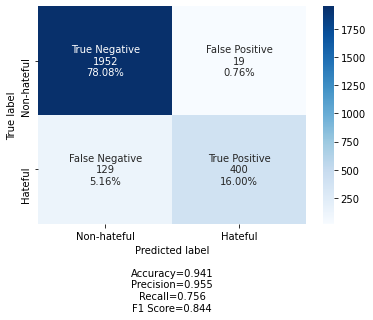

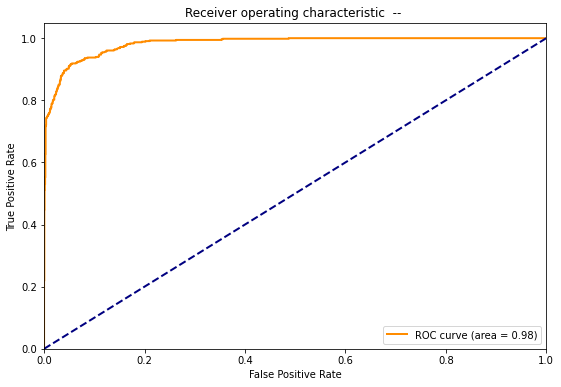

-----------------------------------------------
0.8163195020934427


In [25]:
plot_results(bert_data, 0.9)

### Output predictions

In [28]:
predictions = new_data
predictions['prediciton_score'] = bert_data['probabilities']
predictions['predictions'] = bert_data['probabilities'] > 0.9

In [29]:
predictions.sample(8)

,Comment_text,Hateful_or_not,Platform,prediciton_score,predictions
1148,"""""@PatrickQuelo: If yo girl cant have homeboys...",1,Twitter,0.958922,True
385,"""""\nI've added another meaning that is missing...",0,Wikipedia,0.446916,False
369,"Article Deletion, hoping for revival \n\nHi, I...",0,Wikipedia,0.414367,False
1111,what about the fact that his employer sent aro...,0,Wikipedia,0.458977,False
103,"""""\n\nRussian topography and administration\n\...",0,Wikipedia,0.460929,False
1645,That figures. You're the disruptive one with t...,0,Wikipedia,0.816862,False
819,hi \n\npoint noted AliveFreeHappy,0,Wikipedia,0.754183,False
1629,complete bullshit - your past is catching up w...,1,Wikipedia,0.885458,False


In [30]:
predictions.to_csv(predictions_output_path)